In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import numpy as np

#from exif import Image

In [7]:
BASE_DATA_PATH = '../data/raw/OCT2017/'
TRAIN_BASE_PATH = '../data/raw/OCT2017/train/'
TEST_BASE_PATH = '../data/raw/OCT2017/test/'

## Create Base Data

Write a program which imports all the metadata about the OCT files as a Pandas DataFrame

In [8]:
parents = ['train', 'test']
children = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

# create a base dataframe from the directory items
names_cache = []
for p in parents:
    for c in children:
        files = os.listdir(os.path.join(BASE_DATA_PATH, p, c))
        instance_type = [ p for i in range(len(files)) ]
        path = [ f'/OCT2017/{p}/{c}' for i in range(len(files))]
        print(f'{p}/{c} contains {len(files)} files')
        names_cache.extend(list(zip(files, path, instance_type)))

oct_df = pd.DataFrame(names_cache, columns=['filename', 'path', 'type'])

# split filename into features
oct_df['disease'] = oct_df['filename'].apply(lambda f: f.split('-')[0])
oct_df['pat_id'] = oct_df['filename'].apply(lambda f: f.split('-')[1])
oct_df['img_id'] = oct_df['filename'].apply(lambda f: f.split('-')[2].split('.')[0])
oct_df['filetype'] = oct_df['filename'].apply(lambda f: f.split('.')[1])
oct_df

train/CNV contains 37205 files
train/DME contains 11348 files
train/DRUSEN contains 8616 files
train/NORMAL contains 26315 files
test/CNV contains 250 files
test/DME contains 250 files
test/DRUSEN contains 250 files
test/NORMAL contains 250 files


,filename,path,type,disease,pat_id,img_id,filetype
0,CNV-5557306-155.jpeg,/OCT2017/train/CNV,train,CNV,5557306,155,jpeg
1,CNV-163081-153.jpeg,/OCT2017/train/CNV,train,CNV,163081,153,jpeg
2,CNV-3537912-28.jpeg,/OCT2017/train/CNV,train,CNV,3537912,28,jpeg
3,CNV-7159021-147.jpeg,/OCT2017/train/CNV,train,CNV,7159021,147,jpeg
4,CNV-8087608-23.jpeg,/OCT2017/train/CNV,train,CNV,8087608,23,jpeg
...,...,...,...,...,...,...,...
84479,NORMAL-5246808-1.jpeg,/OCT2017/test/NORMAL,test,NORMAL,5246808,1,jpeg
84480,NORMAL-2733663-1.jpeg,/OCT2017/test/NORMAL,test,NORMAL,2733663,1,jpeg
84481,NORMAL-557437-2.jpeg,/OCT2017/test/NORMAL,test,NORMAL,557437,2,jpeg
84482,NORMAL-3059523-1.jpeg,/OCT2017/test/NORMAL,test,NORMAL,3059523,1,jpeg


## Check for Duplicate Data

Do some investigative queries:
- duplicate data

In [9]:
len(oct_df['filename'].unique())

83605

Looks to be 879 duplicate instances

In [10]:
duplicate_files = oct_df[oct_df['filename'].duplicated()]
duplicate_files = duplicate_files.sort_values(by=['filename'], ascending=True)
duplicate_files

,filename,path,type,disease,pat_id,img_id,filetype
83664,CNV-1016042-1.jpeg,/OCT2017/test/CNV,test,CNV,1016042,1,jpeg
83551,CNV-1016042-2.jpeg,/OCT2017/test/CNV,test,CNV,1016042,2,jpeg
83601,CNV-1016042-3.jpeg,/OCT2017/test/CNV,test,CNV,1016042,3,jpeg
83501,CNV-1016042-4.jpeg,/OCT2017/test/CNV,test,CNV,1016042,4,jpeg
83656,CNV-103044-1.jpeg,/OCT2017/test/CNV,test,CNV,103044,1,jpeg
...,...,...,...,...,...,...,...
84346,NORMAL-84466-1.jpeg,/OCT2017/test/NORMAL,test,NORMAL,84466,1,jpeg
84429,NORMAL-85367-1.jpeg,/OCT2017/test/NORMAL,test,NORMAL,85367,1,jpeg
84368,NORMAL-9053621-1.jpeg,/OCT2017/test/NORMAL,test,NORMAL,9053621,1,jpeg
84350,NORMAL-9251-1.jpeg,/OCT2017/test/NORMAL,test,NORMAL,9251,1,jpeg


In [11]:
duplicate_files['type'].value_counts()

test    879
Name: type, dtype: int64

In [12]:
oct_df[oct_df.filename == 'CNV-1016042-1.jpeg']

,filename,path,type,disease,pat_id,img_id,filetype
26516,CNV-1016042-1.jpeg,/OCT2017/train/CNV,train,CNV,1016042,1,jpeg
83664,CNV-1016042-1.jpeg,/OCT2017/test/CNV,test,CNV,1016042,1,jpeg


🔥 All duplicate files are replicated in both test and train directories. With the Pandas `duplicated()` method, we mark all items as duplicates except for the first occurrence. Since we traverse training directories first in the dataframe creation, all files in the test directory are marked as duplicates.
- 🔑 Potential Solution: Combine all training and test data and conduct a shuffle and (re)split of the data into a training, validation, and test set of images.

Testing if files have metadata associated with them

In [9]:
with open(os.path.join(BASE_DATA_PATH, 'train', 'CNV', 'CNV-1016042-1.jpeg'), 'rb') as i:
    img = Image(i)

print(img.get_all())

{}


Using free and online tools, some metadata does exist:
- image width: 768
- image heigh: 496

## Get Patient ID Counts

In [13]:
pat_df = pd.DataFrame(oct_df.groupby('pat_id').size()).reset_index()
pat_df.columns = ['pat_id', 'instance_count']
pat_df

,pat_id,instance_count
0,1001666,10
1,1001772,10
2,1004480,14
3,100580,8
4,1007507,2
...,...,...
4652,997190,16
4653,9983517,1
4654,9992052,2
4655,9997417,10


In [14]:
pat_df['instance_count'].describe()

count    4657.000000
mean       18.141293
std        42.736217
min         1.000000
25%         4.000000
50%         6.000000
75%        13.000000
max       817.000000
Name: instance_count, dtype: float64

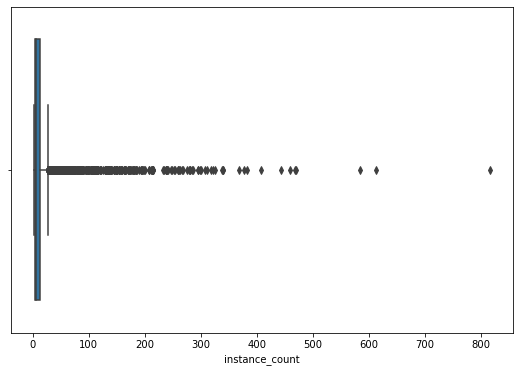

In [15]:
fig, ax = plt.subplots(1, figsize=[9, 6])
ax = sns.boxplot(data=pat_df, x='instance_count')

plt.show()

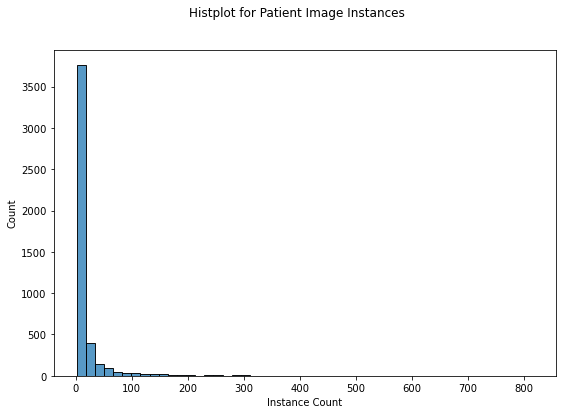

In [16]:
fig, ax = plt.subplots(1, figsize=[9, 6])
ax = sns.histplot(data=pat_df, x='instance_count', bins=50)
ax.set_xlabel('Instance Count')
plt.suptitle('Histplot for Patient Image Instances')
plt.show()

## Report
- 84,484 total instances
- 83,605 unique instances
    - train/CNV contains 37205 files
    - train/DME contains 11348 files
    - train/DRUSEN contains 8616 files
    - train/NORMAL contains 26315 files
    - test/CNV contains 250 files
    - test/DME contains 250 files
    - test/DRUSEN contains 250 files
    - test/NORMAL contains 250 files
- High standard deviation for number of instances per patient

## Get Image size distributions

In [13]:
#test cv2
i = BASE_DATA_PATH+'train/CNV/CNV-1016042-1.jpeg'
img = cv2.imread(i)
dimensions = img.shape
print(dimensions)

(496, 512, 3)


In [14]:
##build filepaths from df

filenames = oct_df.filename.tolist()
paths = oct_df.path.tolist()

file_paths = [] 
for i in range(len(paths)):
    file_paths.append('../data/raw'+paths[i]+'/'+filenames[i])

In [15]:
##get heights, widths, channels of each image - will map back to df
heights = []
widths = []
channels = []
for i in file_paths:
    img = cv2.imread(i)
    dimensions = img.shape
    heights.append(dimensions[0])
    widths.append(dimensions[1])
    channels.append(dimensions[-1])

In [16]:
#reassign img sizes to respective images
oct_df['img_height'] = heights
oct_df['img_width'] = widths
oct_df['num_channels'] = channels

array([<AxesSubplot:title={'center':'img_height'}>], dtype=object)

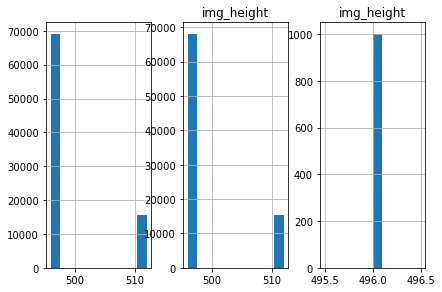

In [17]:
##Look at all the distributions of heights and if these distros differ by type
fig,axs = plt.subplots(1,3)
fig.tight_layout()
plt.subplots_adjust(wspace=10)
oct_df['img_height'].hist(ax=axs[0])
oct_df.loc[oct_df['type'] == 'train',['img_height']].hist(ax=axs[1])
oct_df.loc[oct_df['type'] == 'test',['img_height']].hist(ax=axs[2])


array([<AxesSubplot:title={'center':'img_width'}>], dtype=object)

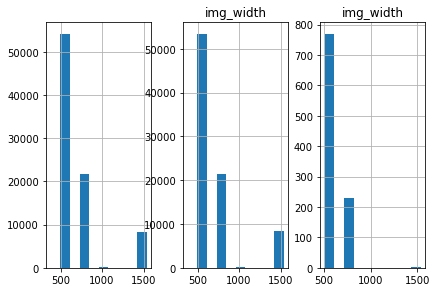

In [18]:

fig,axs = plt.subplots(1,3)
fig.tight_layout()
plt.subplots_adjust(wspace=10)
oct_df['img_width'].hist(ax=axs[0])
oct_df.loc[oct_df['type'] == 'train',['img_width']].hist(ax=axs[1])
oct_df.loc[oct_df['type'] == 'test',['img_width']].hist(ax=axs[2])

array([<AxesSubplot:title={'center':'num_channels'}>], dtype=object)

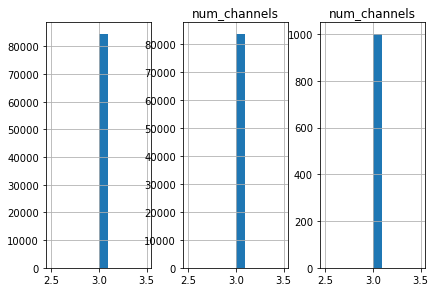

In [57]:
fig,axs = plt.subplots(1,3)
fig.tight_layout()
plt.subplots_adjust(wspace=10)
oct_df['num_channels'].hist(ax=axs[0])
oct_df.loc[oct_df['type'] == 'train',['num_channels']].hist(ax=axs[1])
oct_df.loc[oct_df['type'] == 'test',['num_channels']].hist(ax=axs[2])


In [20]:
oct_df[['img_width','img_height','num_channels']].describe()

,img_width,img_height,num_channels
count,84484.000000,84484.000000,84484.0
mean,680.788978,498.927134,3.0
std,304.950318,6.185991,0.0
min,384.000000,496.000000,3.0
25%,512.000000,496.000000,3.0
50%,512.000000,496.000000,3.0
75%,768.000000,496.000000,3.0
max,1536.000000,512.000000,3.0


In [21]:
oct_df.loc[oct_df['type'] == 'test', ['type','img_width','img_height']].describe()

,img_width,img_height
count,1000.000000,1000.0
mean,571.904000,496.0
std,112.008538,0.0
min,512.000000,496.0
25%,512.000000,496.0
50%,512.000000,496.0
75%,512.000000,496.0
max,1536.000000,496.0


## Take aways from img sizes
1. Good news~ We have 3 channels for everything!
2. For the most part, the images appear to be the same height... at least in the test set
3. We have some pretty real variation in the image widths... it appears we have a majority of the data in the 512 px bin, but we have some massive outliers in the max image width

## Explore 'duplicates'

In [75]:
duplicate_files.reset_index()

,index,filename,path,type,disease,pat_id,img_id,filetype,test_file_size,train_file_size,test_train_equal_size,sameness_percent
0,83664,CNV-1016042-1.jpeg,/OCT2017/test/CNV,test,CNV,1016042,1,jpeg,"(496, 512, 3)","(496, 512, 3)",1,0.025241
1,83551,CNV-1016042-2.jpeg,/OCT2017/test/CNV,test,CNV,1016042,2,jpeg,"(496, 512, 3)","(496, 512, 3)",1,0.019244
2,83601,CNV-1016042-3.jpeg,/OCT2017/test/CNV,test,CNV,1016042,3,jpeg,"(496, 768, 3)","(496, 512, 3)",0,-1.000000
3,83501,CNV-1016042-4.jpeg,/OCT2017/test/CNV,test,CNV,1016042,4,jpeg,"(496, 512, 3)","(496, 512, 3)",1,0.032644
4,83656,CNV-103044-1.jpeg,/OCT2017/test/CNV,test,CNV,103044,1,jpeg,"(496, 512, 3)","(496, 768, 3)",0,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
874,84346,NORMAL-84466-1.jpeg,/OCT2017/test/NORMAL,test,NORMAL,84466,1,jpeg,"(496, 512, 3)","(496, 768, 3)",0,-1.000000
875,84429,NORMAL-85367-1.jpeg,/OCT2017/test/NORMAL,test,NORMAL,85367,1,jpeg,"(496, 512, 3)","(512, 512, 3)",0,-1.000000
876,84368,NORMAL-9053621-1.jpeg,/OCT2017/test/NORMAL,test,NORMAL,9053621,1,jpeg,"(496, 512, 3)","(496, 768, 3)",0,-1.000000
877,84350,NORMAL-9251-1.jpeg,/OCT2017/test/NORMAL,test,NORMAL,9251,1,jpeg,"(496, 512, 3)","(496, 512, 3)",1,0.018622


In [76]:
##Initialize empty lists so we can populate images 
test_size = []
train_size = []
same_size = []
ratio = []

In [77]:
for index,row in duplicate_files.iterrows():
    i = '../data/raw'+row.path+'/'+row.filename
    j = '../data/raw/OCT2017/train/'+(row.path.split('/')[-1])+'/'+row.filename
    img_i = cv2.imread(i)
    img_j = cv2.imread(j)
    test_size.append(img_i.shape)
    train_size.append(img_j.shape)
    if img_i.shape == img_j.shape:
        same_size.append(1)
        ratio.append((img_i == img_j).sum()/(img_i.shape[0]*img_i.shape[1]*img_i.shape[-1]))
    else:
        same_size.append(0)
        ratio.append(-1)

In [78]:
duplicate_files['test_file_size'] = test_size
duplicate_files['train_file_size'] = train_size
duplicate_files['test_train_equal_size'] = same_size
duplicate_files['sameness_percent'] = ratio

In [79]:
duplicate_files[].describe()

,test_train_equal_size,sameness_percent
count,879.000000,879.000000
mean,0.343572,-0.616690
std,0.475171,0.552722
min,0.000000,-1.000000
25%,0.000000,-1.000000
50%,0.000000,-1.000000
75%,1.000000,0.021688
max,1.000000,1.000000


In [102]:
duplicate_files.loc[(duplicate_files['test_train_equal_size'] == 1) & 
                   (duplicate_files['sameness_percent'] >= 0.5)].describe()

,test_train_equal_size,sameness_percent
count,25.0,25.0
mean,1.0,1.0
std,0.0,0.0
min,1.0,1.0
25%,1.0,1.0
50%,1.0,1.0
75%,1.0,1.0
max,1.0,1.0


In [103]:
high_pixel_match_dup_files = duplicate_files.loc[(duplicate_files['test_train_equal_size'] == 1) & 
                   (duplicate_files['sameness_percent'] >= 0.5)]

In [104]:
high_pixel_match_dup_files.reset_index()

,index,filename,path,type,disease,pat_id,img_id,filetype,test_file_size,train_file_size,test_train_equal_size,sameness_percent
0,83700,CNV-1784116-1.jpeg,/OCT2017/test/CNV,test,CNV,1784116,1,jpeg,"(496, 512, 3)","(496, 512, 3)",1,1.0
1,83554,CNV-1997439-1.jpeg,/OCT2017/test/CNV,test,CNV,1997439,1,jpeg,"(496, 512, 3)","(496, 512, 3)",1,1.0
2,83673,CNV-3119854-1.jpeg,/OCT2017/test/CNV,test,CNV,3119854,1,jpeg,"(496, 512, 3)","(496, 512, 3)",1,1.0
3,83757,DME-7650134-1.jpeg,/OCT2017/test/DME,test,DME,7650134,1,jpeg,"(496, 512, 3)","(496, 512, 3)",1,1.0
4,83771,DME-7983936-1.jpeg,/OCT2017/test/DME,test,DME,7983936,1,jpeg,"(496, 768, 3)","(496, 768, 3)",1,1.0
5,83780,DME-8847144-1.jpeg,/OCT2017/test/DME,test,DME,8847144,1,jpeg,"(496, 768, 3)","(496, 768, 3)",1,1.0
6,83857,DME-9579219-1.jpeg,/OCT2017/test/DME,test,DME,9579219,1,jpeg,"(496, 512, 3)","(496, 512, 3)",1,1.0
7,83853,DME-9603124-1.jpeg,/OCT2017/test/DME,test,DME,9603124,1,jpeg,"(496, 512, 3)","(496, 512, 3)",1,1.0
8,84187,DRUSEN-1786810-1.jpeg,/OCT2017/test/DRUSEN,test,DRUSEN,1786810,1,jpeg,"(496, 768, 3)","(496, 768, 3)",1,1.0
9,84071,DRUSEN-2156263-1.jpeg,/OCT2017/test/DRUSEN,test,DRUSEN,2156263,1,jpeg,"(496, 512, 3)","(496, 512, 3)",1,1.0


In [105]:
train_list = []
test_list = []
for index, row in high_pixel_match_dup_files.iterrows():
    test_list.append('../data/raw'+row.path+'/'+row.filename)
    train_list.append('../data/raw/OCT2017/train/'+(row.path.split('/')[-1])+'/'+row.filename)


In [106]:
print(len(train_list), len(test_list))

25 25


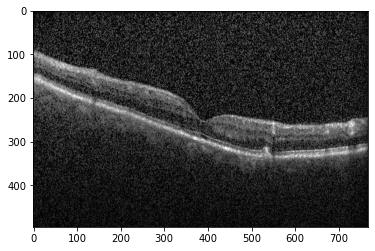

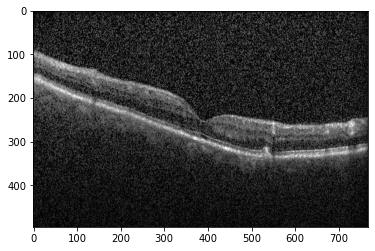

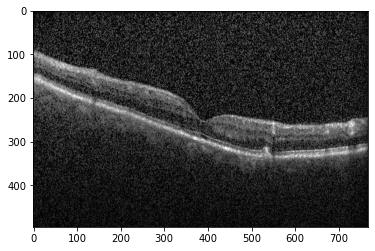

In [109]:
ind = 15
img_i = cv2.imread(train_list[ind])
img_j = cv2.imread(test_list[ind])
plt.imshow(img_i)
plt.show()
plt.imshow(img_j)
plt.show()
added_image = cv2.addWeighted(img_i, 0.5, img_j, 0.5, 0)
plt.imshow(added_image)

## Notes:
The above section shows us that while we have duplicate files names in the test/train folders there are only around ~25 with a pixel-pixel sameness above 50%. Over laying these images, and plotting them side by side, show they are the same. I vote we just drop them. Open to discussion